In [1]:
# Importing the libraries
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout, GRU, Bidirectional
from keras.optimizers import SGD
import math
from sklearn.metrics import mean_squared_error

2025-06-03 12:54:04.730069: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1748955244.935993      35 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1748955244.998827      35 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:

def return_rmse(test,predicted):
    rmse = math.sqrt(mean_squared_error(test, predicted))
    print("The root mean squared error is {}.".format(rmse))

In [3]:
df = pd.read_csv(
    '/kaggle/input/tempura/Dataset_NH3_and_H2S_March_to_April.csv',
    sep=',',
    parse_dates=['Timestamp'],
    low_memory=False,
    na_values=['nan', '?'],
    index_col='Timestamp'
)

df =df.iloc[:,:2]

In [4]:
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
	n_vars = 1 if type(data) is list else data.shape[1]
	dff = pd.DataFrame(data)
	cols, names = list(), list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(dff.shift(i))
		names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(dff.shift(-i))
		if i == 0:
			names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
		else:
			names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
	# put it all together
	agg = pd.concat(cols, axis=1)
	agg.columns = names
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg
 

In [5]:
import os
import wandb
from wandb.integration.keras import WandbCallback

os.environ["WANDB_LOG_MODEL"] = "false"
os.environ["WANDB_API_KEY"] = "05e77228f87f2442c1158e950b18e36123dd4c6c"

In [7]:
wandb.init(project="Gru-forecasting-final-nh3-h2s", config={
    "epochs": 10,
    "batch_size": 32,
    "optimizer": "adam",
    "loss_function": "mean_squared_error",
})

In [8]:
class GruDataPreparer:
    def __init__(self, df: pd.DataFrame, n_in: int = 3, n_out: int = 1, test_days: int = 365):
        self.df = df.copy()
        self.n_in = n_in
        self.n_out = n_out
        self.test_days = test_days
        self.n_features = df.shape[1]
        self.scaler = MinMaxScaler(feature_range=(0, 1))
        self.reframed = None
        self.model = None

        self.train_X = None
        self.train_y = None
        self.test_X = None
        self.test_y = None

    def preprocess(self):
        values = self.df.values.astype('float32')
        scaled = self.scaler.fit_transform(values)
        self.reframed = series_to_supervised(scaled, self.n_in, self.n_out)
        return self.reframed

    def create_train_test(self):
        if self.reframed is None:
            self.preprocess()

        values = self.reframed.values
        test_size = self.test_days * 24
        train = values[:-test_size, :]
        test = values[-test_size:, :]

        n_obs = self.n_in * self.n_features
        self.train_X, self.train_y = train[:, :n_obs], train[:, n_obs:]
        self.test_X, self.test_y = test[:, :n_obs], test[:, n_obs:]

        self.train_X = self.train_X.reshape((self.train_X.shape[0], self.n_in, self.n_features))
        self.test_X = self.test_X.reshape((self.test_X.shape[0], self.n_in, self.n_features))

        print("Shapes:")
        print("train_X:", self.train_X.shape)
        print("train_y:", self.train_y.shape)
        print("test_X:", self.test_X.shape)
        print("test_y:", self.test_y.shape)

    def inverse_transform_y(self, y_scaled):
        dummy = np.zeros((y_scaled.shape[0], self.n_features))
        dummy[:, :y_scaled.shape[1]] = y_scaled
        return self.scaler.inverse_transform(dummy)[:, :y_scaled.shape[1]]

    def train_model(self):
        if self.train_X is None or self.train_y is None:
            self.create_train_test()

        self.model = Sequential()
        self.model.add(GRU(units=50, return_sequences=True, input_shape=( self.train_X.shape[1], self.train_X.shape[2])))
        self.model.add(Dropout(0.2))
        self.model.add(GRU(units=50, return_sequences=True))
        self.model.add(Dropout(0.2))
        self.model.add(GRU(units=50, return_sequences=True))
        self.model.add(Dropout(0.2))
        self.model.add(GRU(units=50))
        self.model.add(Dropout(0.2))
        self.model.add(Dense(units=self.n_features))
        self.model.compile(optimizer=SGD(learning_rate=0.01, decay=1e-7, momentum=0.9), loss='mean_squared_error')


        history = self.model.fit(
            self.train_X, self.train_y,
            epochs=wandb.config.epochs,
            batch_size=wandb.config.batch_size,
            validation_data=(self.test_X, self.test_y),
            verbose=2,
            shuffle=False,
            callbacks=[WandbCallback(
                save_model=False,
                log_weights=True,
                log_evaluation=False,
                save_graph=False
            )]
        )

        plt.plot(history.history['loss'])
        plt.plot(history.history['val_loss'])
        plt.title('Model Loss')
        plt.ylabel('Loss')
        plt.xlabel('Epoch')
        plt.legend(['Train', 'Test'], loc='upper right')
        plt.show()

    def evaluate(self):
        if self.model is None:
            raise ValueError("Model is not trained yet.")
        if self.test_X is None or self.test_y is None:
            self.create_train_test()

        y_pred = self.model.predict(self.test_X)
        y_pred_scaled = self.inverse_transform_y(y_pred)
        y_true_scaled = self.inverse_transform_y(self.test_y)
        for i in range(y_pred.shape[1]):
            rmse = np.sqrt(mean_squared_error(self.test_y[:, i], y_pred[:, i]))
            print(f"Test Scaled RMSE var{i+1}: {rmse:.3f}")
        for i in range(y_pred.shape[1]):
            rmse = np.sqrt(mean_squared_error(y_true_scaled[:, i], y_pred_scaled[:, i]))
            print(f"Test RMSE var{i+1}: {rmse:.3f}")

Shapes:
train_X: (86208, 24, 2)
train_y: (86208, 2)
test_X: (168, 24, 2)
test_y: (168, 2)


I0000 00:00:1748955325.321172      35 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/optimizers/base_optimizer.py:86: UserWarning: Argument `decay` is no longer supported and will be ignored.
  warnings.warn(
wandb: WARNING WandbCallback is deprecated and will be removed in a future release. Please use the WandbMetricsLogger, WandbModelCheckpoint, and WandbEvalCallback callbacks instead. See https://docs.wandb.ai/guides/integrations/keras for more information.


Epoch 1/10


I0000 00:00:1748955330.005669     122 cuda_dnn.cc:529] Loaded cuDNN version 90300


2694/2694 - 25s - 9ms/step - loss: 0.0511 - val_loss: 0.0053
Epoch 2/10
2694/2694 - 19s - 7ms/step - loss: 0.0045 - val_loss: 0.0019
Epoch 3/10
2694/2694 - 19s - 7ms/step - loss: 0.0028 - val_loss: 0.0013
Epoch 4/10
2694/2694 - 19s - 7ms/step - loss: 0.0023 - val_loss: 0.0012
Epoch 5/10
2694/2694 - 20s - 7ms/step - loss: 0.0021 - val_loss: 0.0011
Epoch 6/10
2694/2694 - 20s - 7ms/step - loss: 0.0019 - val_loss: 7.0604e-04
Epoch 7/10
2694/2694 - 20s - 7ms/step - loss: 0.0018 - val_loss: 9.4837e-04
Epoch 8/10
2694/2694 - 20s - 7ms/step - loss: 0.0018 - val_loss: 7.4393e-04
Epoch 9/10
2694/2694 - 20s - 7ms/step - loss: 0.0016 - val_loss: 5.9356e-04
Epoch 10/10
2694/2694 - 20s - 7ms/step - loss: 0.0016 - val_loss: 9.9891e-04


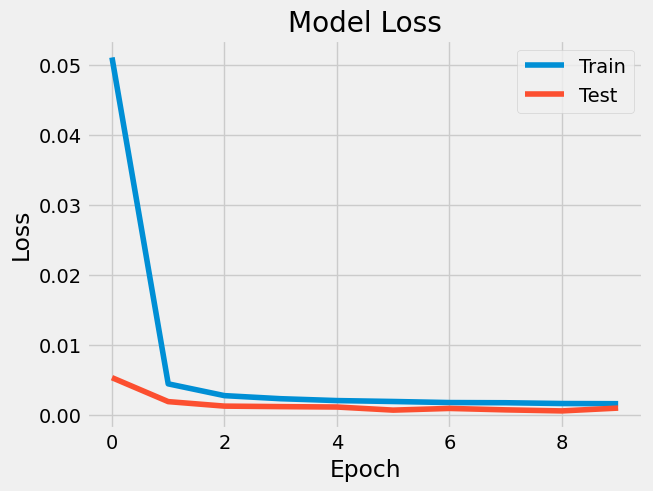

In [9]:
modell = GruDataPreparer(df, n_in=24, n_out=1,test_days=7)
modell.train_model()


In [10]:
modell.evaluate()
modell.model.save("gru.h5")

6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 82ms/step
Test Scaled RMSE var1: 0.033
Test Scaled RMSE var2: 0.030
Test RMSE var1: 0.835
Test RMSE var2: 0.197
